In [220]:
library(tidyverse)
library(tidymodels)
library(grid)
library(gridExtra)
# Gabriel Pereira

In [221]:
# Download the file and read into notebook
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip",temp)
school_data <- read_csv2(unz(temp, "student-mat.csv"))
unlink(temp)

# Select relevant columns
school_data <- school_data %>% filter(school == "GP", age != 20, age != 22) %>%
    select(age,absences,G1,G2,G3)
school_data

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



age,absences,G1,G2,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,6,5,6,6
17,4,5,5,6
15,10,7,8,10
15,2,15,14,15
16,4,6,10,10
16,10,15,15,15
16,0,12,12,11
17,6,6,5,6
15,0,16,18,19


In [202]:
#see if predictors are linear

In [203]:
# Checks to see if the dataframe has any NA values. 
any(is.na(data))

[1] FALSE

In [204]:
# Split data into training and testing. Strata by age to ensure the
# the sample has 
school_split <- initial_split(data, prop = 3/4, strata = age)
school_training <- training(school_split)
school_testing <- testing(school_split)

In [206]:
options(repr.plot.width = 10, repr.plot.height = 10)

What is the students predicted final grade, based on their previous quarter grades, studytime, and number of absences?

`summarise()` regrouping output by 'age' (override with `.groups` argument)



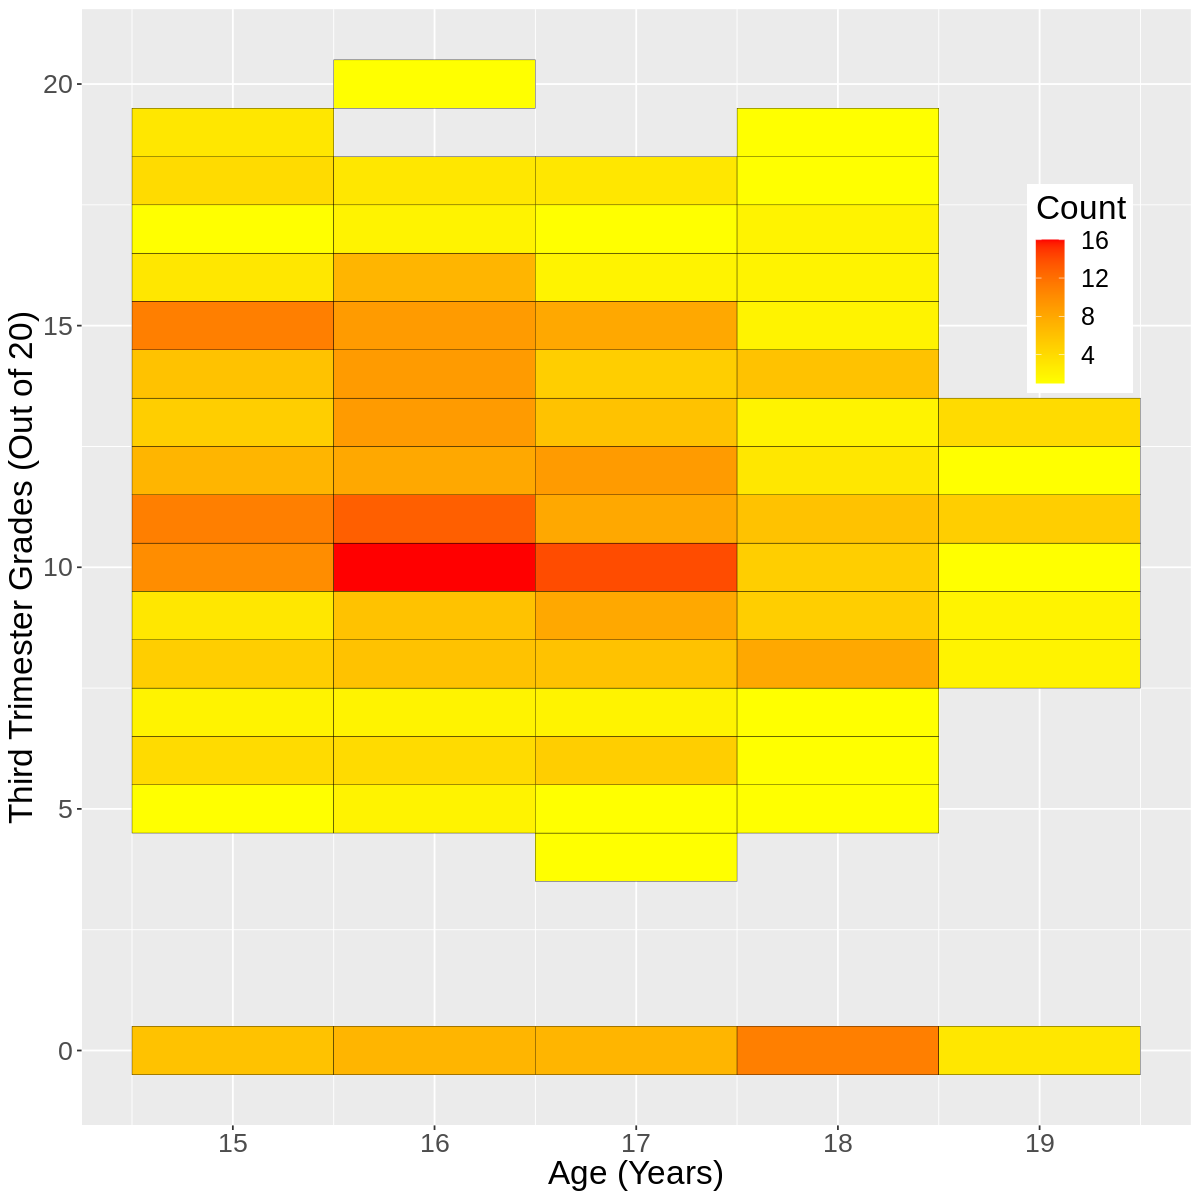

In [155]:
grade_3_vs_age_plot <- school_data %>%
                        select(age, G3) %>%
                        group_by(age, G3) %>%
                        summarize(n = n()) %>%
                        ggplot(aes(x = age, y = G3, fill = n)) +
                            geom_tile(color = "black") +
                            labs(x = "Age (Years)", y = "Third Trimester Grades (Out of 20)", fill = "Count") +
                            scale_fill_gradient(low = "yellow", high = "red") +
                            theme(text = element_text(size = 20),
                                 legend.position = c(0.90,0.75),
                                 legend.text = element_text(size = 15))
grade_3_vs_age_plot

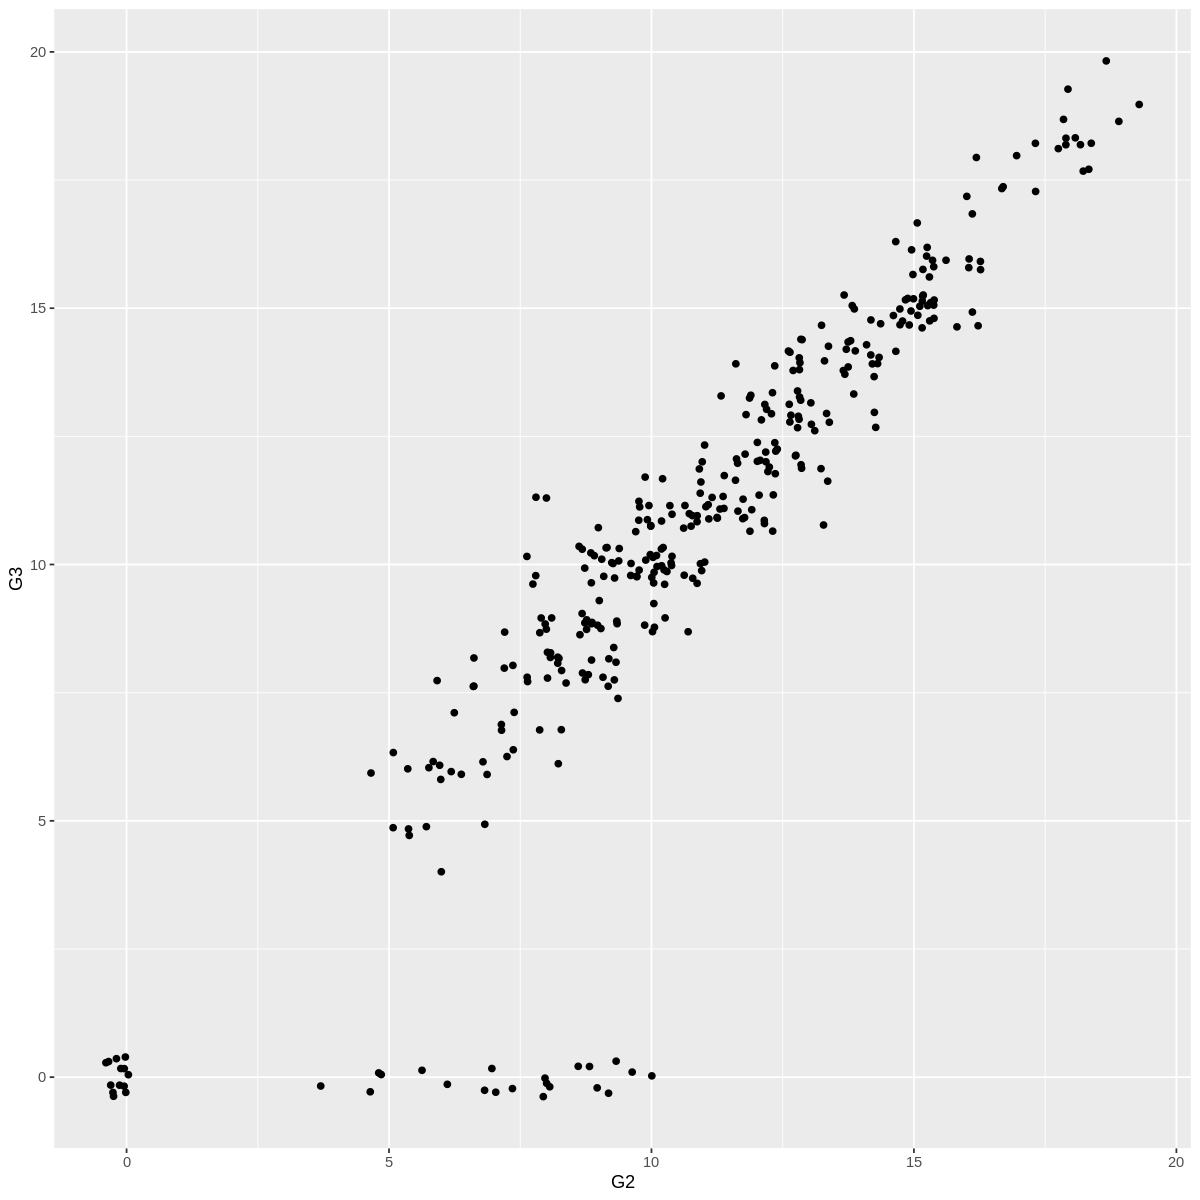

In [157]:
ggplot(school_data, aes(x = G2, y = G3)) +
    geom_point(position = "jitter")

In [226]:
G2_scatterplot <- ggplot(school_data, aes(x = G2, y = G3, alpha = 0.3)) +
                geom_point(position = "jitter") +
                labs(title = "Figure 1",
                     x = "Second Trimester Grades (Out of 20)",
                     y = "Third Trimester Grades (Out of 20)") +
                theme(text = element_text(size = 20),
                     legend.position = "none")
G1_scatterplot <- ggplot(school_data, aes(x = G1, y = G3, alpha = 0.3)) +
                geom_point(position = "jitter") +
                labs(title = "Figure 2",
                     x = "First Trimester Grades (Out of 20)",
                     y = "Third Trimester Grades (Out of 20)") +
                theme(text = element_text(size = 20),
                     legend.position = "none")
absences_scatterplot <- ggplot(school_data, aes(x = absences, y = G3, alpha = 0.3)) +
                geom_point(position = "jitter") +
                labs(title = "Figure 3",
                     x = "Number of Absences",
                     y = "Third Trimester Grades (Out of 20)") +
                theme(text = element_text(size = 20),
                     legend.position = "none")
age_boxplot <- 
    school_data %>%
    mutate(age = as_factor(age)) %>%
    mutate(age = case_when(age == "15" ~ "Age 15",
                          age == "16" ~ "Age 16",
                          age == "17" ~ "Age 17",
                          age == "18" ~ "Age 18",
                          age == "19" ~ "Age 19")) %>%
    ggplot() +
    geom_boxplot(aes(y= G3, fill = age)) +
    facet_grid(. ~ age) +
    labs(title = "Figure 4", y = "Third Trimester Grades (Out of 20)", fill = "Age") +
    theme(text = element_text(size = 20),
          axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          legend.position = "none")

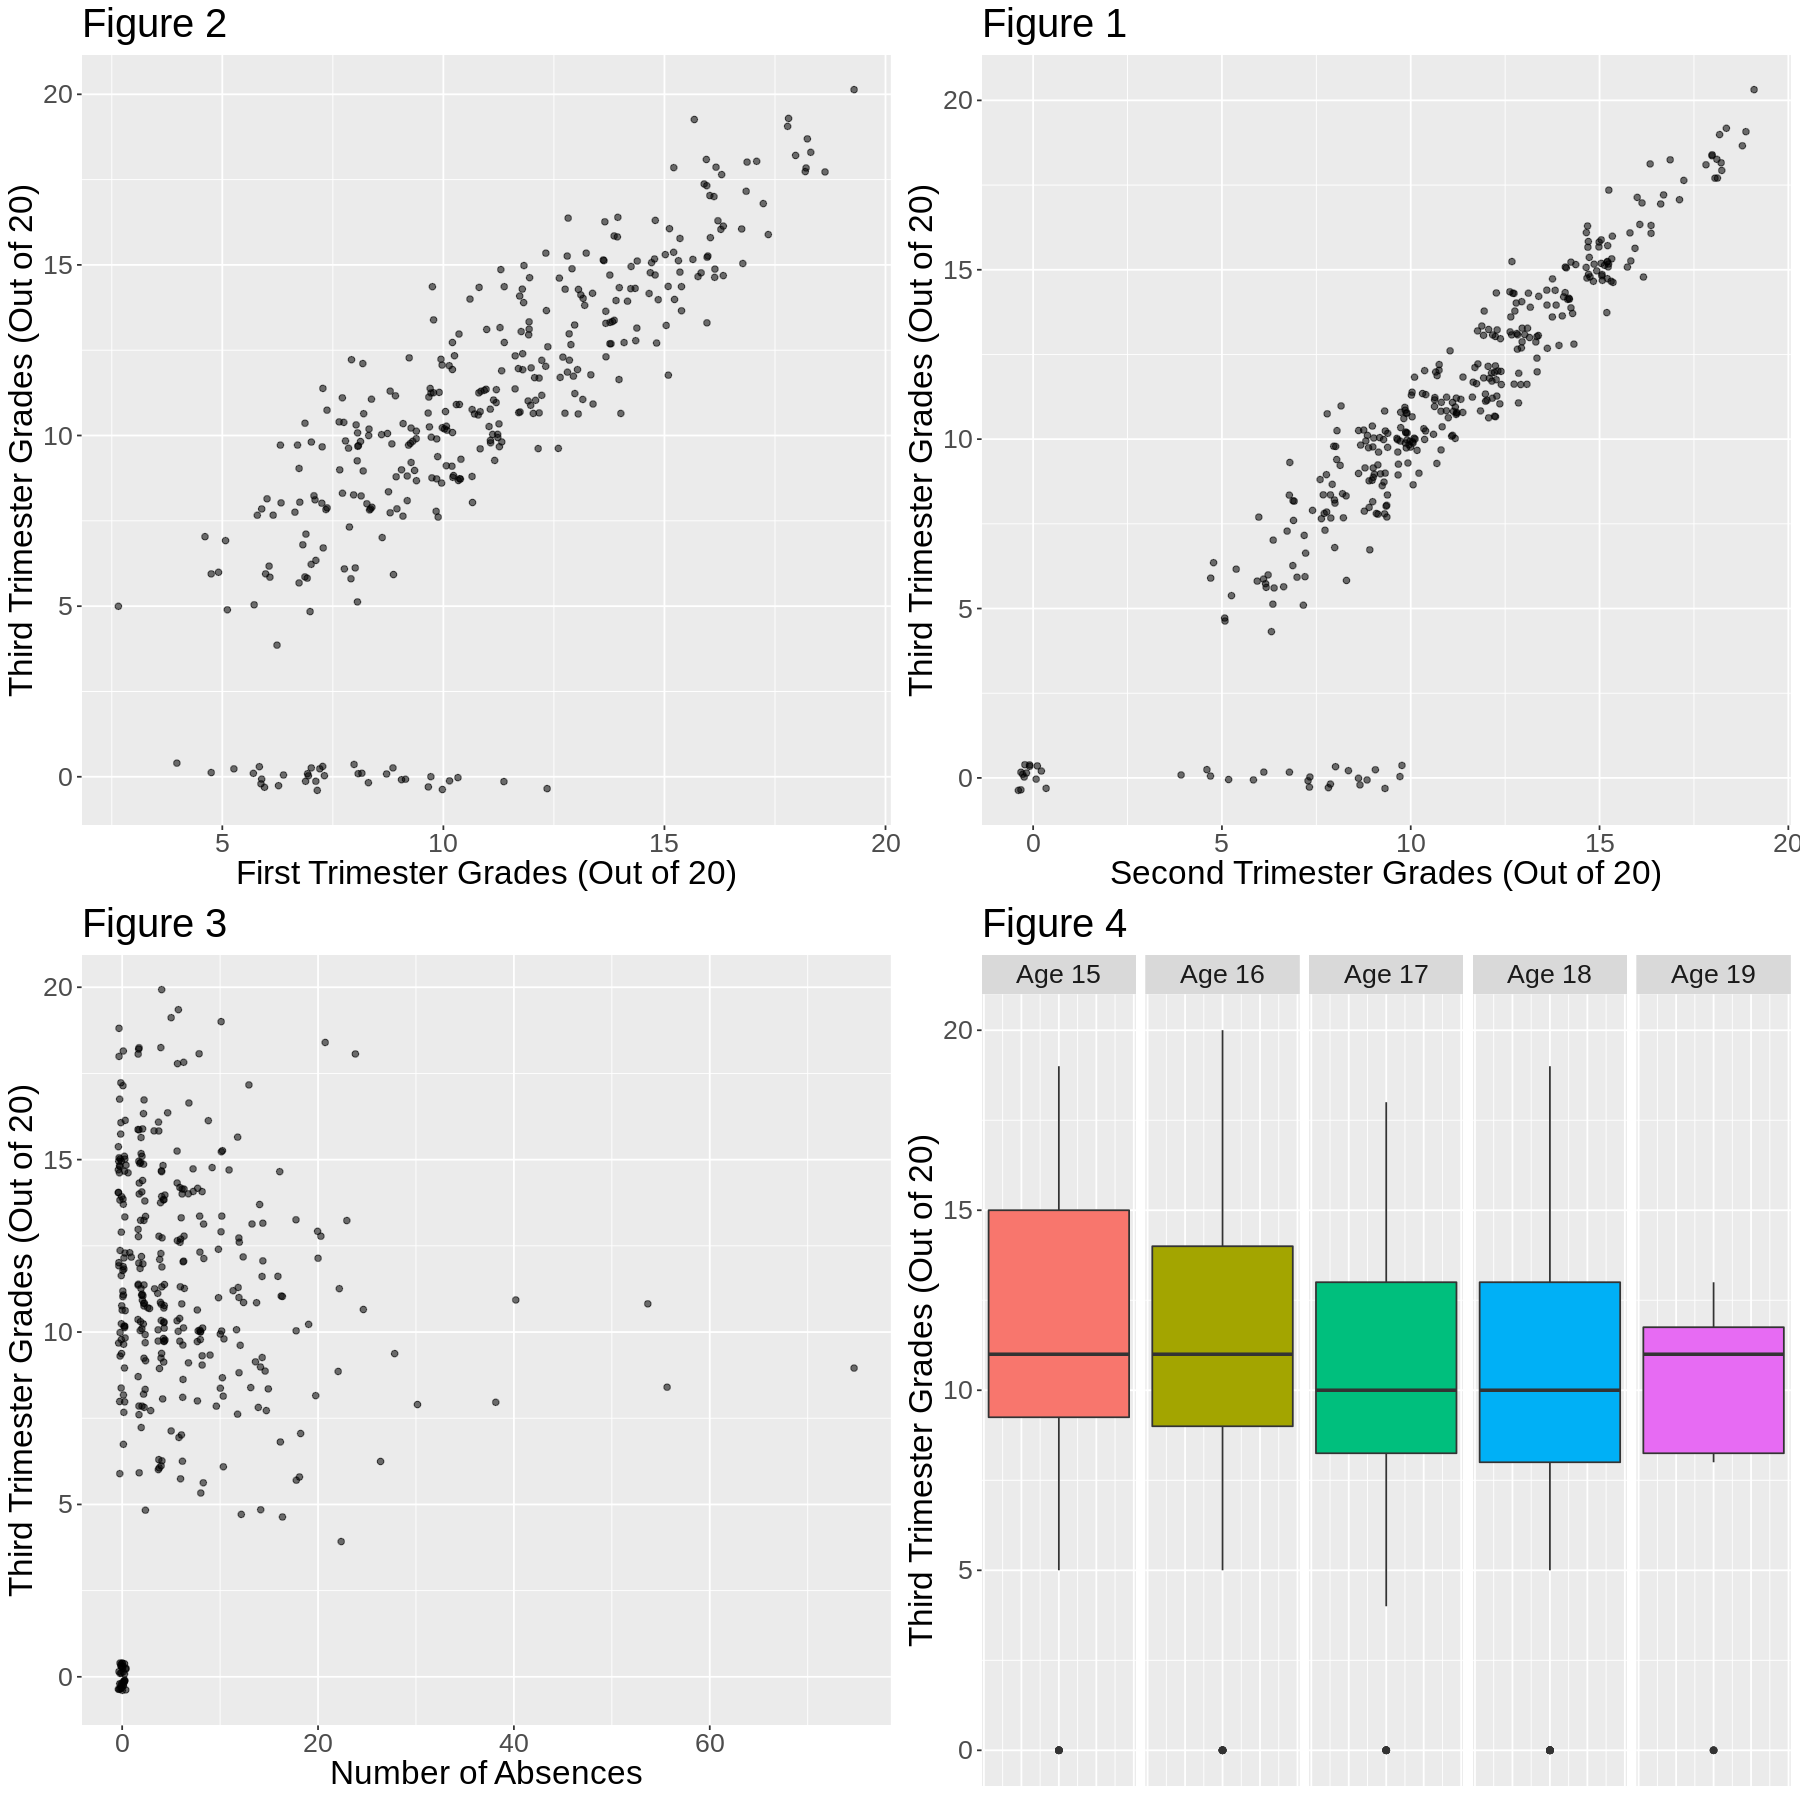

In [228]:
options(repr.plot.width = 15, repr.plot.height = 15)
grid.arrange(G1_scatterplot, G2_scatterplot, absences_scatterplot,age_boxplot,nrow = 2, ncol = 2)